In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from tensorflow.keras.layers import *
from keras.src.backend import Variable
import tensorflow as tf

2024-04-10 09:52:24.532514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 09:52:25.412789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data and flatten images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Verification subset
X_subset = x_train[:1000]
y_subset = y_train[:1000]



In [5]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

<Axes: >

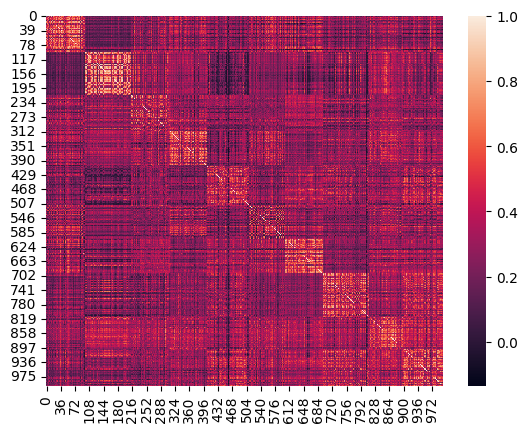

In [6]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

In [1]:
def euclid_distances_tf(X):
    sum_square = tf.reduce_sum(tf.square(X), axis=1)
    distances = tf.sqrt(sum_square[:, tf.newaxis] + sum_square - 2 * tf.matmul(X, X, transpose_b=True)+1e-4)
    return distances



In [7]:

distances = euclid_distances_tf(X_ordered)


2024-04-10 09:52:32.840424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 09:52:32.976050: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


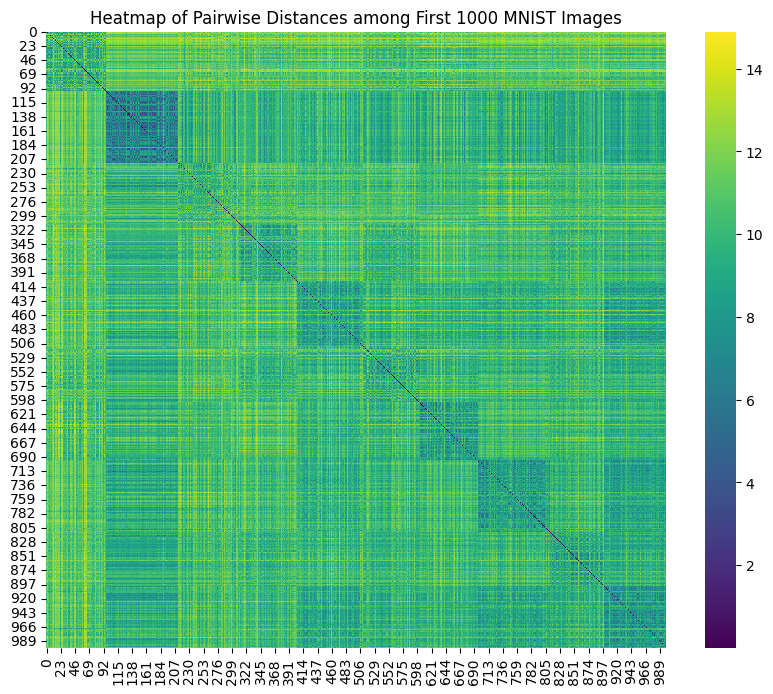

In [8]:

# Plot heatmap of the pairwise distances matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distances, cmap='viridis')
plt.title('Heatmap of Pairwise Distances among First 1000 MNIST Images')
plt.show()

# domowe tSNE

In [8]:
# def correlation(matrix):
#     # same as numpy.corrcoef but for tensorflow
#     means = tf.reduce_mean(matrix, axis=1, keepdims=True)
#     diff = matrix - means
#     dot_products = tf.matmul(diff, diff, transpose_b=True)
#     norms = tf.norm(diff, axis=1, keepdims=True)
#     return dot_products / tf.matmul(norms, norms, transpose_b=True)

# def correlation_loss(X, Y):
#     return tf.reduce_mean((correlation(X) - correlation(Y))**2)

In [9]:


# Define a custom loss function based on Euclidean distances
def euclid_loss_tf(y_true, y_pred):
    return tf.reduce_mean((euclid_distances_tf(y_true) - euclid_distances_tf(y_pred))**2)

In [10]:
latent_dim = 2
model = Sequential([
    Input(shape=(784,)),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(latent_dim, activation="tanh"),
])

model.compile(optimizer="adam", loss=euclid_loss_tf)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         3,202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,018 (86.01 KB)

 Trainable params: 22,018 (86.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
type(X_ordered)

numpy.ndarray

In [11]:
history = model.fit(X_ordered, X_ordered, epochs=100, batch_size=256, shuffle=True, validation_data=(X_ordered, X_ordered))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 97.6894 - val_loss: 92.5854
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 93.7610 - val_loss: 88.1707
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 88.8518 - val_loss: 82.7385
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 84.0755 - val_loss: 78.1066
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 80.0246 - val_loss: 75.1658
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 76.6653 - val_loss: 73.3168
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 75.5258 - val_loss: 72.1663
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 74.9144 - val_loss: 71.4474
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 73.9298 - val_loss: 70.9977
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 73.9942 - val_loss: 70.5782
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 74.2290 - val_loss: 70.2804
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step -

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1000, 20)


<Axes: >

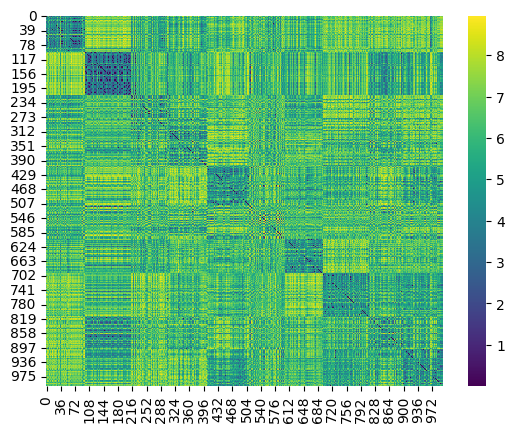

In [13]:
embeddings = model.predict(X_ordered)
print(embeddings.shape)
sns.heatmap(euclid_distances_tf(embeddings), cmap='viridis')



# t-sne for euclidan distences

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

def load_mnist_subset(n_samples=1000):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data[:n_samples]
    y = mnist.target[:n_samples]
    return StandardScaler().fit_transform(X), y.astype(int)

def get_pairwise_euclidean_distances(X: np.ndarray) -> np.ndarray:
    n = len(X)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(X[i] - X[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def compute_loss(Y: np.ndarray, original_distances: np.ndarray) -> float:
    n = Y.shape[0]
    loss = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            d_ij_low_dim = np.linalg.norm(Y[i] - Y[j])
            diff = d_ij_low_dim - original_distances[i, j]
            loss += diff**2
    return loss

def adjust_positions(Y: np.ndarray, Y_prev_move: np.ndarray, original_distances: np.ndarray, learning_rate: float, randomness_factor: float, momentum: float = 0.8) -> tuple:
    n = Y.shape[0]
    Y_move = np.zeros_like(Y)  # Initialize move array

    for i in range(n):
        for j in range(i + 1, n):
            d_ij = np.linalg.norm(Y[i] - Y[j])
            diff = d_ij - original_distances[i, j]

            # Calculate the deterministic move vector
            deterministic_move = (Y[i] - Y[j]) * (diff / (d_ij + 1e-6))
            
            # Apply exponential scaling to the move vector
            exponential_move =  deterministic_move * learning_rate
            
            # Incorporate randomness
            random_vector = np.random.randn(*Y[i].shape) * randomness_factor
            
            # Combine the deterministic, exponential, and random moves
            move = exponential_move + random_vector
            
            # Apply momentum
            move += momentum * Y_prev_move[i]

            Y[i] -= move
            Y[j] += move
            Y_move[i] -= move  # Update the move for momentum calculation in the next iteration
            Y_move[j] += move

    return Y, Y_move



def tsne_modified(X: np.ndarray, y, n_dimensions: int = 2, initial_eta: float = 0.01, eta_increase_factor: float = 1., initial_randomness: float = 0.001, randomness_decay: float = 0.95, momentum: float = 0.001, output_dir: str = './tsne_iterations', loss_threshold: float = 1e-4, check_frequency: int = 50, increase_frequency: int = 500, adjust_randomness_frequency: int = 50):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Use PCA for initialization
    pca = PCA(n_components=n_dimensions)
    Y = pca.fit_transform(X)
    original_distances = get_pairwise_euclidean_distances(X)
    Y_move = np.zeros_like(Y)  # For applying momentum

    eta = initial_eta  # Initial learning rate
    randomness_factor = initial_randomness  # Initial randomness factor

    t = 0
    losses = []
    while True:
        Y, Y_move_new = adjust_positions(Y, Y_move, original_distances, eta, randomness_factor, momentum)
        Y_move = Y_move_new  # Update the move for the next iteration
        
        current_loss = compute_loss(Y, original_distances)
        losses.append(current_loss)
        print(f"Iteration {t}: Loss = {current_loss}, Learning Rate = {eta}, Randomness = {randomness_factor}, Momentum = {momentum}")

        plt.figure(figsize=(8, 6))
        plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
        plt.colorbar()
        plt.title(f'MNIST Visualized with Modified t-SNE at Iteration {t}, Loss: {current_loss:.2f}, η: {eta:.4f}, Randomness: {randomness_factor:.4f}')
        plt.savefig(f'{output_dir}/iteration_{t:03d}.png')
        plt.close()

        #if t % check_frequency == 0 and t > 0:
       #     if len(losses) > check_frequency and current_loss - losses[-check_frequency] > -loss_threshold:
         #       print(f"Stopping: Loss change {current_loss - losses[-check_frequency]} is less than threshold {loss_threshold} after {t} iterations.")
       #         break
        if t % adjust_randomness_frequency == 0 and t > 0:
            randomness_factor *= randomness_decay
        if t % increase_frequency == 0 and t > 0:
            eta *= eta_increase_factor

        if t % adjust_randomness_frequency == 0 and t > 0:
            randomness_factor *= randomness_decay
        if t % 10 == 0:  # Clear output every 10 iterations
            clear_output(wait=True)
        t += 1  # Increment iteration counter

    print("Completed Adjustment of Low Dimensional Embeddings.")

if __name__ == "__main__":
    X, y = load_mnist_subset(n_samples=100)  # Adjust based on your computational capabilities
    tsne_modified(X, y.astype(int), n_dimensions=2, output_dir='tsne_iterations')


Iteration 21: Loss = 501747.6246137235, Learning Rate = 0.01, Randomness = 0.001, Momentum = 0.001
Iteration 22: Loss = 501404.5057267585, Learning Rate = 0.01, Randomness = 0.001, Momentum = 0.001


KeyboardInterrupt: 